# Set up

## Google Drive Set-up

In [1]:
"""from google.colab import drive
drive.mount('/content/drive')"""

ModuleNotFoundError: No module named 'google.colab'

In [3]:
# Set current working directory to the project folder in gdrive
import os
root_dir = os.getcwd()
project_dir = str(root_dir)
print(project_dir)

c:\Users\weiha\project\Satellite_Image_Segmentation\notebooks


## Import Libraries

In [2]:
#!pip install patchify
#!pip install opencv-python
#!pip install split-folders
#!pip install albumentations

In [4]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from patchify import patchify
import splitfolders
import albumentations as A
import shutil 

## Useful Functions

In [9]:
def split_image(patch_size, image_dir, dataset_dir, mask = False):
  # Loop into the directories and get images
  for root, sub_dirs, files in os.walk(image_dir): # get image directory and each file name
    for file in files: 
      #print(file)
      img_path = os.path.join(root, file)
      if mask:
        image = cv2.imread(img_path, 0) # this is the actual image read from the image path
      else:
        image = cv2.imread(img_path, 1) # this is the actual image read from the image path

      # Plot the image before croppping
      """plt.figure()
      f, ax = plt.subplots(1,2, figsize = (20, 8))
      ax[0].imshow(image)
      ax[0].set_title(f"Before Crop: {image.shape}")"""
      
      ## We will now divide the large image into patches of smaller images 
      # first, crop the image to a size which is closest to the size divisible by 256
      size_x = (image.shape[1] // patch_size) * patch_size # Get the closest size
      size_y = (image.shape[0] // patch_size) * patch_size # Get the closest size
      image = Image.fromarray(image) # Using pillow, convert the image np array into a PIL image in order to use the crop function
      image = image.crop((0 ,0, size_x, size_y)) # PIL.Image.crop(box) --> box defines the "coordinate" of the crop area we want
      image = np.array(image) # Then, convert the image back to np array
      
      # Plot image after cropping
      """ax[1].imshow(image)
      ax[1].set_title(f"After Crop: {image.shape}")"""

      # Next, get the smaller patches
      if mask:
        patches = patchify(image, (256, 256), step=256)  # we just need 1 dimension for masks
      else:
        patches = patchify(image, (256, 256, 3), step=256)  # RGB (3 dimensions) for images
      print(patches.shape)
      for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
          if mask:
            single_patch = patches[i,j] # Single mask
            #print(np.unique(single_patch, return_counts = True))
          else:
            single_patch = patches[i,j][0] # Single image

          # Show patch
          #print(single_patch.shape)
          #plt.imshow(single_patch[:,:,0])

          if mask:
            cv2.imwrite(dataset_dir+"256_patches/all/masks/" + file+"_patch_"+str(i)+str(j)+".tif", single_patch)
          else: 
            cv2.imwrite(dataset_dir+"256_patches/all/images/" + file+"_patch_"+str(i)+str(j)+".tif", single_patch)
          #break
        #break
      print(f"{file} done")

  
      #break

## Import Images

Dataset from: https://landcover.ai.linuxpolska.com/

In [31]:
# Visualize an image
temp_image = cv2.imread(project_dir +'/Dataset/images/M-33-7-A-d-2-3.tif', 1)
temp_image.shape # Resolution and 3 bands

(9711, 9081, 3)

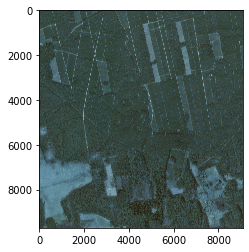

In [32]:
# Visualize all three bands
plt.imshow(temp_image[:,:]);

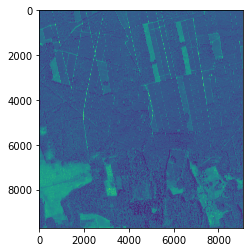

In [199]:
plt.imshow(temp_image[:,:,1])

In [200]:
# Visualize a mask
temp_mask = cv2.imread(project_dir + '/Dataset/masks/M-33-7-A-d-2-3.tif')
temp_mask.shape # Resolution and 3 bands

(9711, 9081, 3)

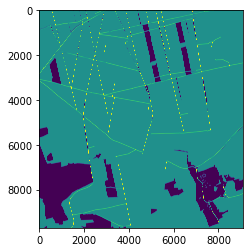

In [201]:
plt.imshow(temp_mask[:,:,0])

In [202]:
labels, count = np.unique(temp_mask[:,:], return_counts=True) #Check for each channel. All chanels are identical
print("Labels are: ", labels, " and the counts are: ", count)

Labels are:  [0 1 2 4]  and the counts are:  [ 31947021    181245 227608305   4820202]


In [89]:
# We will read all the images to the unique labels
original_mask_dir = project_dir + "/Dataset/masks/"
for mask in os.listdir(original_mask_dir):
    temp_mask = cv2.imread(original_mask_dir+mask, 0)
    print(np.unique(temp_mask, return_counts=True))

(array([0, 1, 2, 3, 4], dtype=uint8), array([18008335,    46512, 59476087,  9553859,   554627], dtype=int64))
(array([0, 1, 2, 3, 4], dtype=uint8), array([51755402,  1071120, 28762038,  3750573,  2254812], dtype=int64))
(array([0, 1, 2, 3, 4], dtype=uint8), array([68480904,     2483,  8634611,  9305876,  1107984], dtype=int64))
(array([0, 1, 2, 3, 4], dtype=uint8), array([48049205,    46774, 31169179,  4760893,   580366], dtype=int64))
(array([0, 1, 2, 4], dtype=uint8), array([10649007,    60415, 75869435,  1606734], dtype=int64))
(array([0, 1, 2, 3, 4], dtype=uint8), array([31180689,   324909, 51703029,  3286107,  1795186], dtype=int64))
(array([0, 1, 2, 3, 4], dtype=uint8), array([54754080,   187027, 13945863, 17531405,   692550], dtype=int64))
(array([0, 1, 2, 3, 4], dtype=uint8), array([49439384,   257813, 17240259, 19427352,   818717], dtype=int64))
(array([0, 1, 2, 3, 4], dtype=uint8), array([73561223,   514709,  8286385,   166417,   788091], dtype=int64))
(array([0, 1, 2, 3, 4],

# Data Preparation

## Divide images into smaller patches

In [33]:
# Define patch size
patch_size = 256

# Define image and mask directory
image_dir = project_dir + "/Dataset/images/"
mask_dir = project_dir + "/Dataset/masks/"

# Define dataset directory for ouput 
dataset_dir = project_dir + "/Dataset/"

In [218]:
# Split images using the pre-defined function - run once
#split_image(patch_size, image_dir, dataset_dir, mask = False)

# Split masks using the predefined function - run once
split_image(patch_size, mask_dir, dataset_dir, mask = True)


(37, 35, 256, 256)
M-33-20-D-c-4-2.tif done
(37, 35, 256, 256)
M-33-20-D-d-3-3.tif done
(37, 35, 256, 256)
M-33-32-B-b-4-4.tif done
(36, 35, 256, 256)
M-33-48-A-c-4-4.tif done
(37, 35, 256, 256)
M-33-7-A-d-2-3.tif done
(37, 35, 256, 256)
M-33-7-A-d-3-2.tif done
(37, 35, 256, 256)
M-34-32-B-a-4-3.tif done
(37, 35, 256, 256)
M-34-32-B-b-1-3.tif done
(36, 34, 256, 256)
M-34-5-D-d-4-2.tif done
(36, 34, 256, 256)
M-34-51-C-b-2-1.tif done
(36, 34, 256, 256)
M-34-51-C-d-4-1.tif done
(37, 35, 256, 256)
M-34-55-B-b-4-1.tif done
(37, 35, 256, 256)
M-34-56-A-b-1-4.tif done
(36, 34, 256, 256)
M-34-6-A-d-2-2.tif done
(36, 35, 256, 256)
M-34-65-D-a-4-4.tif done
(36, 35, 256, 256)
M-34-65-D-c-4-2.tif done
(36, 35, 256, 256)
M-34-65-D-d-4-1.tif done
(37, 36, 256, 256)
M-34-68-B-a-1-3.tif done
(36, 35, 256, 256)
M-34-77-B-c-2-3.tif done
(37, 34, 256, 256)
N-33-104-A-c-1-1.tif done
(18, 17, 256, 256)
N-33-119-C-c-3-3.tif done
(37, 34, 256, 256)
N-33-130-A-d-3-3.tif done
(37, 34, 256, 256)
N-33-130-A-d-4

In [223]:
# make sure that the masks are 1 channel with labels
mask_output_dir = project_dir + "/Dataset/256_patches/all/masks"
for root, sub_dir, files in os.walk(mask_output_dir):
    for file in files[0:5]:
        mask_256 = cv2.imread(os.path.join(root, file))
        print(np.unique(mask_256, return_counts=True))
        #plt.imshow(mask_256[:,:,0])
        #break

(array([2], dtype=uint8), array([196608], dtype=int64))
(array([0, 2], dtype=uint8), array([ 29175, 167433], dtype=int64))
(array([2], dtype=uint8), array([196608], dtype=int64))
(array([0, 2], dtype=uint8), array([128328,  68280], dtype=int64))
(array([0, 2, 4], dtype=uint8), array([108489,  72453,  15666], dtype=int64))


## Choose only images with significantly different labels

In [35]:
# Directories of image patches
patch_image_dir = project_dir + "/Dataset/256_patches/all/images"

patch_mask_dir = project_dir + "/Dataset/256_patches/all/masks"

# File names of images and patches
patch_images_list = os.listdir(patch_image_dir)
patch_masks_list = os.listdir(patch_mask_dir)
print(f"No. of images: {len(patch_images_list)}, No. of masks: {len(patch_masks_list)}")

# Function to select useful images/masks and save selection to a new folder 
for root, sub_dir, files in os.walk(patch_mask_dir):
    for i, file in enumerate(files):
        if i%100 == 0:
            print(f"{i} images processed") # notify every 100 images
    
        mask_path = os.path.join(root, file)
        image_path = os.path.join(patch_image_dir, file)
        mask = cv2.imread(mask_path)
        image = cv2.imread(image_path)

        #plt.imshow(mask[:,:,0])

        # Get pixel counts for unique labels for mask
        # and save both images and masks to a new folder
        pixel_counts = np.unique(mask, return_counts=True)[1]
        pixel_percentage = pixel_counts / pixel_counts.sum()
        if max(pixel_percentage) < 0.95:
            cv2.imwrite(dataset_dir+"256_patches/chosen/chosen_masks/" + file, mask) # write mask
            cv2.imwrite(dataset_dir+"256_patches/chosen/chosen_images/" + file, image) # write image
            
""""""

No. of images: 41646, No. of masks: 41646
0 images processed
100 images processed
200 images processed
300 images processed
400 images processed
500 images processed
600 images processed
700 images processed
800 images processed
900 images processed
1000 images processed
1100 images processed
1200 images processed
1300 images processed
1400 images processed
1500 images processed
1600 images processed
1700 images processed
1800 images processed
1900 images processed
2000 images processed
2100 images processed
2200 images processed
2300 images processed
2400 images processed
2500 images processed
2600 images processed
2700 images processed
2800 images processed
2900 images processed
3000 images processed
3100 images processed
3200 images processed
3300 images processed
3400 images processed
3500 images processed
3600 images processed
3700 images processed
3800 images processed
3900 images processed
4000 images processed
4100 images processed
4200 images processed
4300 images processed
44

36000 images processed
36100 images processed
36200 images processed
36300 images processed
36400 images processed
36500 images processed
36600 images processed
36700 images processed
36800 images processed
36900 images processed
37000 images processed
37100 images processed
37200 images processed
37300 images processed
37400 images processed
37500 images processed
37600 images processed
37700 images processed
37800 images processed
37900 images processed
38000 images processed
38100 images processed
38200 images processed
38300 images processed
38400 images processed
38500 images processed
38600 images processed
38700 images processed
38800 images processed
38900 images processed
39000 images processed
39100 images processed
39200 images processed
39300 images processed
39400 images processed
39500 images processed
39600 images processed
39700 images processed
39800 images processed
39900 images processed
40000 images processed
40100 images processed
40200 images processed
40300 image

''

In [36]:
# See number of files in each folder

num_masks = next(files for root, sub_dir, files in os.walk(dataset_dir+"256_patches/chosen/chosen_masks/"))
print("No. of masks: ", len(num_masks))

num_images = next(files for root, sub_dir, files in os.walk(dataset_dir+"256_patches/chosen/chosen_images/"))
print("No. of images: ", len(num_images))

print("Different files: ", list(set(num_images).difference(set(num_masks))))

# We end up with 20133 images and masks from the entire dataset

No. of masks:  20133
No. of images:  20133
Different files:  []


## Split into train, validation and test folders

In [80]:
original_folder_chosen= dataset_dir+"256_patches/chosen/" # original chosen folder

output_folder = dataset_dir+"256_patches/modeling_dataset/" # Folder to save the train, val and test folders

In [81]:
splitfolders.ratio(original_folder_chosen, output=output_folder, seed=42, ratio=(.85, 0.1,0.05), move = False) 

Copying files: 40266 files [04:03, 165.45 files/s]


In [82]:
# See if the file names in each folder are the same 
folder_path = dataset_dir+"256_patches/modeling_dataset/"
folder_names = ['train', 'val', 'test']
sub_folder_names = ['chosen_images', 'chosen_masks']

for f in folder_names:
  f_path = [folder_path + f + '/' + sf for sf in sub_folder_names]
  sf1 = os.listdir(f_path[0])
  sf2 = os.listdir(f_path[1])
  if len(set(sf1).difference(set(sf2))) == 0:
    print(f"Same file names for image and masks for: {f} folder")
  else:
    print("The following files are different:\n", set(sf1).difference(set(sf2)))


"""Run once to produce the folder structure"""

Same file names for image and masks for: train folder
Same file names for image and masks for: val folder
Same file names for image and masks for: test folder


'Run once to produce the folder structure'

## Image augmentation

In [83]:
folder_path = dataset_dir+"256_patches/modeling_dataset/"
folder_names = ['train']
sub_folder_names = ['chosen_images', 'chosen_masks']

In [84]:
# Loop through folders
# read image and mask
# perform augmentation on image
# Save image and mask under same name
for f in folder_names:
    img_dir = folder_path + f + "/" + sub_folder_names[0] + '/'
    mask_dir = folder_path + f + "/" + sub_folder_names[1] + '/'
    # read image and masks
    files = os.listdir(img_dir)
    print(f"Processing {f} folder with {len(files)} files")
    count = 0
    for file in files:
        image = cv2.imread(img_dir + file, 1)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_dir + file, 0)
        
        # set up transformation parameters
        transform_bc = A.Compose([
            A.RandomBrightnessContrast(p=1),
        ])
        transformed = transform_bc(image=image)
        image_t1 = transformed['image']

        """plt.subplot(1,3,1)
        plt.imshow(image)
        plt.subplot(1,3,2)
        plt.imshow(mask)
        plt.subplot(1,3,3)
        plt.imshow(image_t)"""
        
        # Write transformed image and mask to drive with a different name
        file_name_t = file[:-4]+'_t1.tif' # add a _t1 suffix
        cv2.imwrite(img_dir + file_name_t, image_t1) # write new image
        
        source_mask = mask_dir + file
        destination_mask = mask_dir + file_name_t
        shutil.copy(source_mask, destination_mask)
        
        # print every 500 files
        count += 1
        if count%500 == 0:
            print(f"{count} images processed for {f} folder")
        #break
    
    #print(files)
    #break

Processing train folder with 17113 files
500 images processed for train folder
1000 images processed for train folder
1500 images processed for train folder
2000 images processed for train folder
2500 images processed for train folder
3000 images processed for train folder
3500 images processed for train folder
4000 images processed for train folder
4500 images processed for train folder
5000 images processed for train folder
5500 images processed for train folder
6000 images processed for train folder
6500 images processed for train folder
7000 images processed for train folder
7500 images processed for train folder
8000 images processed for train folder
8500 images processed for train folder
9000 images processed for train folder
9500 images processed for train folder
10000 images processed for train folder
10500 images processed for train folder
11000 images processed for train folder
11500 images processed for train folder
12000 images processed for train folder
12500 images proces